In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
sys.path.append('..')

from singleVis.SingleVisualizationModel import VisModel

from singleVis.data import NormalDataProvider

from singleVis.projector import DVIProjector,TimeVisProjector
from singleVis.eval.evaluator import Evaluator

VIS_METHOD = "DVI" # DeepVisualInsight

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################
CONTENT_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]


SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)



/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-05 14:31:40.900516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 14:31:41.463270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-05 14:31:41.463321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Finish initialization...


In [2]:
epoch = 100
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border

####### get proxy ########
from trustVis.skeleton_generator import CenterSkeletonGenerator
# skeleton_generator = SkeletonGenerator(data_provider,epoch)
# high_bom = skeleton_generator.skeleton_gen_use_perturb(_epsilon=1e-3)
skeleton_generator = CenterSkeletonGenerator(data_provider,epoch,3,3,1000)
high_bom,radis = skeleton_generator.center_skeleton_genertaion()

finished init


100%|██████████| 8/8 [00:00<00:00, 11401.44it/s]


max_radius 42.57566452026367 interval 544
[16.579836 20.353725 13.276573 ... 14.404306 24.379475 13.443714]
Successfully load the DVI visualization model for iteration 100
Successfully load the DVI visualization model for iteration 100
Computing decision regions ...
Successfully load the DVI visualization model for iteration 100
Successfully load the DVI visualization model for iteration 100
grid_samples (40000, 512)


100%|██████████| 256/256 [00:00<00:00, 7836.44it/s]


Successfully load the DVI visualization model for iteration 100


100%|██████████| 256/256 [00:00<00:00, 7833.36it/s]


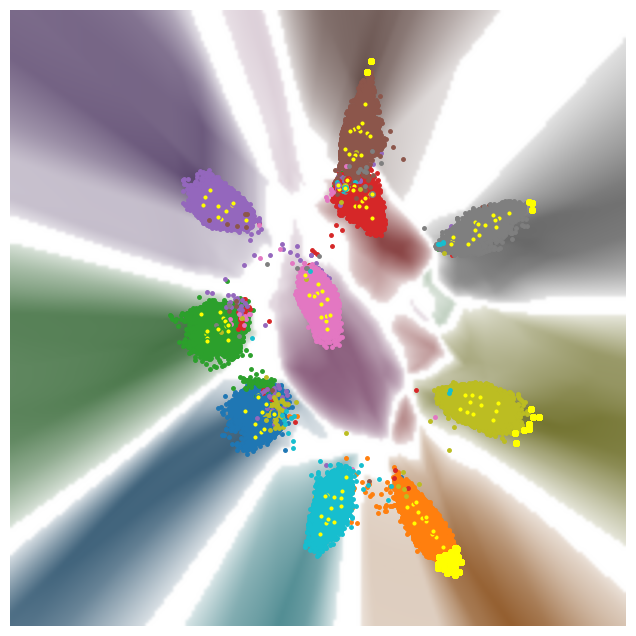

In [119]:

from trustVis.skeleton_generator import SkeletonGenerator
skeleton_generator = SkeletonGenerator(data_provider,epoch)
border_ = skeleton_generator.skeleton_gen_use_perturb(_epsilon=1e-1)
# high_bom = skeleton_generator.skeleton_gen()

# centers = gen_skeleton_by_center(epoch)
high_bom_ = np.concatenate((border_,high_bom),axis = 0)
# high_bom_c = high_bom[-1:] # open to see sk
# high_bom_b = high_bom[:360]# open to see border

# high_bom = np.concatenate((high_bom_c, high_bom_b),axis = 0)



X = np.concatenate((high_bom_, data_provider.train_representation(epoch)))
# X = high_bom_
border = np.zeros(len(X))

border[:len(border_)] = 2
# border[:300] = 2

border[len(border_):len(high_bom_)] = 1

border_elements_emd = projector.batch_project(epoch, X)


vis_model_name = 'trustvis_sk'
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=vis_model_name, device=DEVICE) 
from singleVis.skeleVis import visualizer

vis = visualizer(data_provider, projector, 200, "tab10", "yellow")

vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 100
Computing decision regions ...
Successfully load the DVI visualization model for iteration 100
Successfully load the DVI visualization model for iteration 100
grid_samples (40000, 512)


100%|██████████| 250/250 [00:00<00:00, 8108.38it/s]


Successfully load the DVI visualization model for iteration 100


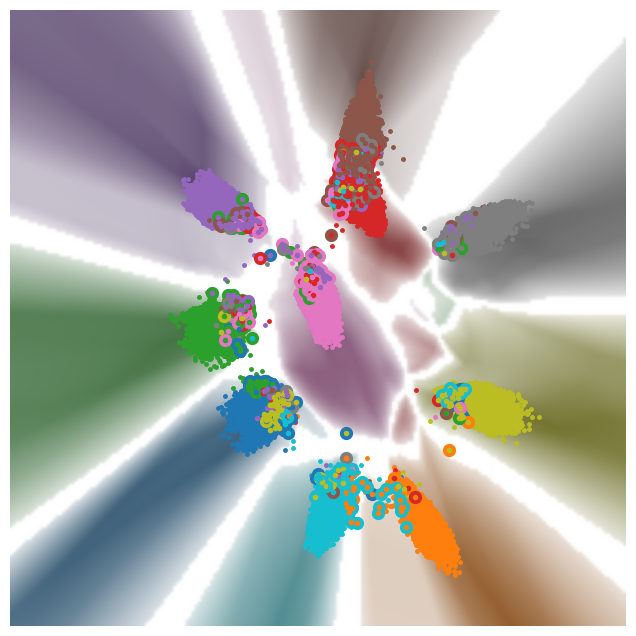

In [120]:
#### show training data
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

In [84]:
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 100
Sat Aug  5 01:35:42 2023 Building RP forest with 16 trees
Sat Aug  5 01:35:43 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sat Aug  5 01:35:44 2023 Building RP forest with 16 trees
Sat Aug  5 01:35:44 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.55/15 in epoch 100


1.55064

In [118]:
from singleVis.eval.evaluator import Evaluator

projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='trustvis_sk', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 100
Sat Aug  5 02:13:58 2023 Building RP forest with 16 trees
Sat Aug  5 02:13:59 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sat Aug  5 02:14:01 2023 Building RP forest with 16 trees
Sat Aug  5 02:14:01 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.52/15 in epoch 100


1.51506

In [121]:
epoch = 100

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='trustvis_sk', device=DEVICE)  
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='vis', device=DEVICE)
training_emd = projector.batch_project(epoch, data_provider.train_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.train_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.train_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 100
Successfully load the DVI visualization model for iteration 100


100%|██████████| 250/250 [00:00<00:00, 7872.19it/s]


vis error num: 630 vis error on boundary:  583 boundary flip: 2867


In [48]:
epoch = 10

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='best', device=DEVICE)  
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='vis', device=DEVICE)
training_emd = projector.batch_project(epoch, data_provider.test_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.test_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.test_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 10
Successfully load the DVI visualization model for iteration 10


100%|██████████| 50/50 [00:00<00:00, 13524.78it/s]

vis error num: 50 vis error on boundary:  28 boundary flip: 59
